In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2.5})
%matplotlib inline
pd.set_option('max_colwidth',150)
pd.set_option('max_rows',500)

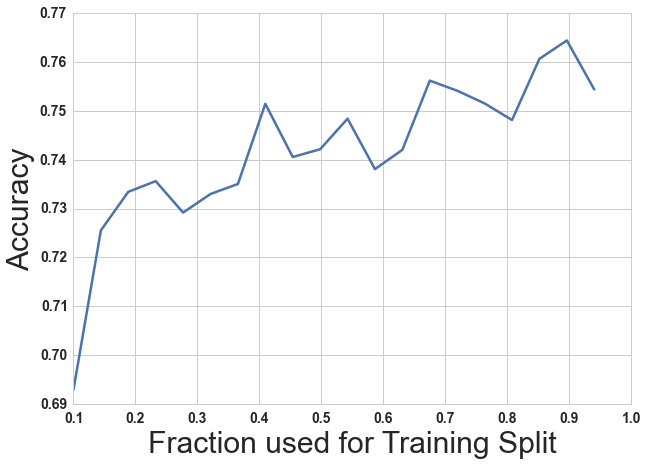

In [330]:
plt.figure(figsize=(10,7))
plt.plot(ts, scores)
plt.xlabel('Fraction used for Training Split', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.show()

In [2]:
from nltk.tag import StanfordNERTagger, StanfordPOSTagger
pos = '/Users/scottcronin/nltk_data/taggers' + \
      '/stanford-postagger-full-2015-04-20/models' + \
      '/english-caseless-left3words-distsim.tagger'
pos_jar = '/Users/scottcronin/nltk_data/taggers' + \
          '/stanford-postagger-full-2015-04-20' + \
          '/stanford-postagger-3.5.2.jar'
st_pos = StanfordPOSTagger(pos, pos_jar)

ner = '/Users/scottcronin/nltk_data/stanford-ner/' + \
      'classifiers/english.all.3class.distsim.crf.ser.gz'
ner_jar = '/Users/scottcronin/nltk_data/stanford-ner/' + \
          'stanford-ner-3.5.2.jar'
st_ner = StanfordNERTagger(ner, ner_jar)

In [3]:
def inv_label_dict(row):
    d = {}
    title = row['_id']
    label = row['labels']
    for k, vs in label.iteritems():
        k = k.replace('[dot]', '.')
        k = k.replace('[dol]', '$')
        for v in vs:
            d[v['position']] = {'word': k,
                                'POS': v['POS'],
                                'label': v['label']}
    return d


def update_POS(row):
    title = row['_id']
    pos_tpls = st_pos.tag(title.split())
#     print datetime.now().time()
    label = row['labels']
    for i, (word, pos) in enumerate(pos_tpls):
        label[i]['POS'] = pos
    return label


def update_ner(row):
    title = row['_id']
    ner_tpls = st_ner.tag(title.split())
    label = row['labels']
    print datetime.now().time()
    for i, (word, ner) in enumerate(ner_tpls):
        label[i]['ner'] = ner
    return label


def word_pct(label):
    word_count = len(label)
    for num in xrange(word_count):
        word_pct = num / float(word_count)
        label[num]['word_pct'] = word_pct
    return label


def all_lower(label):
    for k, v in label.iteritems():
        label[k]['all_lower'] = v['word'].islower()
    return label


def all_upper(label):
    for k, v in label.iteritems():
        label[k]['all_upper'] = v['word'].isupper()
    return label

In [ ]:
df = pd.read_pickle('../Data/pr_train_labelled_475_v1.pkl')
df['labels'] = df.apply(inv_label_dict, axis=1)
df['labels'] = df.apply(update_POS, axis=1)
df.to_pickle('../Data/feat_pos.pkl')

In [163]:
df = pd.read_pickle('../Data/feat_pos_ner.pkl')
df = df[df['horf'] == 'Hired']
df['labels'] = df['labels'].apply(word_pct)
df['labels'] = df['labels'].apply(all_lower)
df['labels'] = df['labels'].apply(all_upper)

In [5]:
for row in df[['_id', 'labels']][:1].values:
    print row[0]
    print '------'
    print row[1]
    print '================================='

Seagis Property Group Announces New Partner Hire
------
{0: {'all_upper': False, 'word': u'Seagis', 'POS': u'NNP', 'label': u'org', 'word_pct': 0.0, 'all_lower': False, 'ner': u'ORGANIZATION'}, 1: {'all_upper': False, 'word': u'Property', 'POS': u'NNP', 'label': u'org', 'word_pct': 0.14285714285714285, 'all_lower': False, 'ner': u'ORGANIZATION'}, 2: {'all_upper': False, 'word': u'Group', 'POS': u'NNP', 'label': u'org', 'word_pct': 0.2857142857142857, 'all_lower': False, 'ner': u'ORGANIZATION'}, 3: {'all_upper': False, 'word': u'Announces', 'POS': u'VBZ', 'label': u'other', 'word_pct': 0.42857142857142855, 'all_lower': False, 'ner': u'ORGANIZATION'}, 4: {'all_upper': False, 'word': u'New', 'POS': u'JJ', 'label': u'other', 'word_pct': 0.5714285714285714, 'all_lower': False, 'ner': u'ORGANIZATION'}, 5: {'all_upper': False, 'word': u'Partner', 'POS': u'NN', 'label': u'position', 'word_pct': 0.7142857142857143, 'all_lower': False, 'ner': u'ORGANIZATION'}, 6: {'all_upper': False, 'word': u'H

In [172]:
tags = ['$', '``', "''", '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX',
        'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
        'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
        'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
        'WP$', 'WRB', 'BOS', 'EOS']
mapping = {'other': 3,
           'org': 0,
           'name': 1,
           'name2': 1,
           'position': 2,
           'O': 3,
           'ORGANIZATION': 0,
           'PERSON': 1,
           'LOCATION': 3}

def vectorize(label):
    df = pd.DataFrame(label).T
    df[['all_lower', 'all_upper', 'word_pct']] = df[['all_lower', 'all_upper', 'word_pct']].astype(float)
    df['POS'] = df['POS'].astype('category', categories=tags)
    y = df['label'].map(mapping).values
    y_stanford = df['ner'].map(mapping).values
    # include POS of num number of words before and after word of interest
    num = 2
    for i in xrange(1,num+1):
        col_pos = 'POS' + '+'*i
        col_neg = 'POS' + '-'*i
        df[col_pos] = df['POS'].shift(-i).fillna('EOS')
        df[col_neg] = df['POS'].shift(i).fillna('BOS')
    df_calcs = df[['word_pct', 'all_lower', 'all_upper']]
    df_pos = pd.get_dummies(df.filter(regex='POS'))
    df = pd.concat([df_calcs, df_pos], axis=1)
    X = df.values
    
#     X = pd.get_dummies(df[['word_pct', 'all_lower', 'all_upper', 'POS']]).values
    return X, y, y_stanford, df

X = []
y = []
y_stanford = []
headlines = []
for row in df[['_id', 'labels']].values:
    headline, label = row[0], row[1]
    headlines.append(headline)
    X1, y1, y1_stanford, test = vectorize(label)
    X.append(X1)
    y.append(y1)
    y_stanford.append(y1_stanford)
X = np.array(X)
y = np.array(y)
y_stanford = np.array(y_stanford)

In [85]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM
from sklearn.naive_bayes import MultinomialNB

In [381]:
X_train, X_test, y_train, y_test, y_st_train, y_st_test, \
hl_train, hl_test = train_test_split(X, y, y_stanford, \
                                     headlines, test_size=0.25)

In [382]:
nmb = MultinomialNB()
nmb.fit(np.vstack(X_train), np.hstack(y_train))

svm = LinearSVC(dual=False, C=.1)
svm.fit(np.vstack(X_train), np.hstack(y_train))

model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=0.5, max_iter=15)
ssvm.fit(X_train, y_train)

print("NMB: %f" % nmb.score(np.vstack(X_test),
                                                   np.hstack(y_test)))
print("SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))
print("CRF: %f" % ssvm.score(X_test, y_test))

NMB: 0.696737
SVM: 0.722649
CRF: 0.743762


In [268]:
1 - np.logspace(-1, -.02, 20)

array([ 0.9       ,  0.88738948,  0.87318872,  0.85719716,  0.83918899,
        0.81890989,  0.79607349,  0.77035731,  0.74139818,  0.70878716,
        0.67206371,  0.63070926,  0.58413979,  0.53169767,  0.47264233,
        0.40613981,  0.33125098,  0.24691828,  0.15195079,  0.04500741])

In [284]:
ts = np.linspace(0.1, 0.94, 20)
scores = []
for t in ts:
    X_train, X_test, y_train, y_test, y_st_train, y_st_test, \
    hl_train, hl_test = train_test_split(X, y, y_stanford, \
                                         headlines, train_size=t,
                                         random_state=42)
    model = ChainCRF()
    ssvm = FrankWolfeSSVM(model=model, C=1, max_iter=15)
    ssvm.fit(X_train, y_train)
    scores.append(ssvm.score(X_test, y_test))

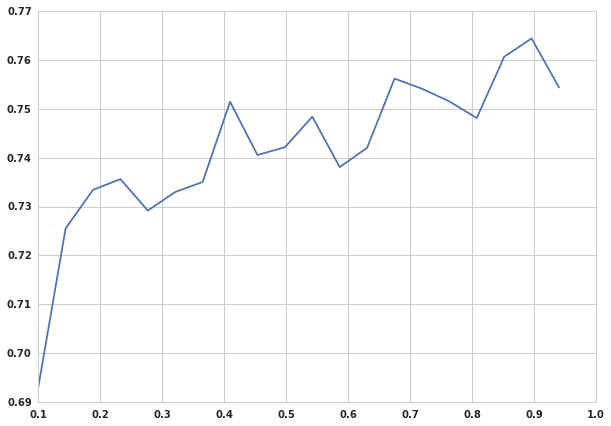

In [303]:
plt.figure(figsize=(10,7))
plt.plot(ts, scores)
# plt.xlabel('Fraction used for Training Split', fontsize=30, labelsize=20)
plt.show()

In [383]:
cs = np.logspace(-4, 4, 30)
mis = np.linspace(2, 25, 24).astype(int)
scores = []
for mi in mis:
    model = ChainCRF()
    ssvm = FrankWolfeSSVM(model=model, C=0.5, max_iter=mi)
    ssvm.fit(X_train, y_train)
    scores.append(ssvm.score(X_test, y_test))

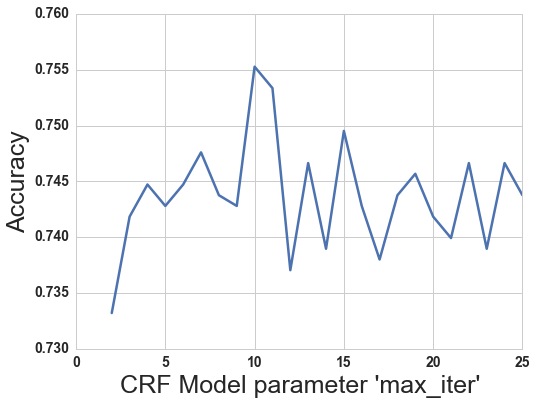

In [384]:
plt.figure(figsize=(8,6))
plt.plot(mis,scores)
plt.xlabel("CRF Model parameter 'max_iter'", fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.show()

In [279]:
def test_scores(y_hat, y_true, y_stanford):
    label = ['Org:', 'Name:', 'Position:', 'Other:']
    for i, l in enumerate(label):
        print '==================' 
        print l
        print ''
        print 'Count: ', sum(np.hstack(y_true) == i)
        print 'My pred: ', np.mean(np.hstack(y_hat)[np.hstack(y_true) == i] == i)
        print 'Stanford: ', np.mean(np.hstack(y_stanford)[np.hstack(y_true) == i] == i)   
    
test_scores(ssvm.predict(X_test), y_test, y_st_test)
# test_scores(ssvm.predict(X), y, y_stanford)

Org:

Count:  151
My pred:  0.715231788079
Stanford:  0.609271523179
Name:

Count:  150
My pred:  0.786666666667
Stanford:  0.813333333333
Position:

Count:  264
My pred:  0.844696969697
Stanford:  0.0
Other:

Count:  289
My pred:  0.750865051903
Stanford:  0.837370242215


In [83]:
i = 0
np.hstack(y_test) == i
print (np.hstack(y_st_test)[np.hstack(y_test) == i] == i).mean()
print (np.hstack(ssvm.predict(X_test))[np.hstack(y_test) == i] == i).mean()


0.832962138085
0.563474387528


In [186]:
for i in xrange(3):
    print y_test[i]
    print hl_test[i]
    print ssvm.predict(X_test)[i]
    print y_st_test[i]
    print '=============='

[0 3 3 3 3 3 3 3 3]
INRIX Hires Former Group Head Of Analytics At Vodafone
[0 3 3 3 2 2 2 2 2]
[0 0 0 0 0 0 0 3 0]
[0 0 3 1 1 2 2 2 3 3 3 1 1 3 3 3 3 3 3]
Express Scripts Names Tim Wentworth Chief Executive Officer, Effective May 2016; George Paz to Retire and Remain as Chairman
[0 0 3 1 1 3 3 3 3 3 3 1 1 3 3 3 3 3 2]
[3 3 3 1 1 3 3 3 3 3 3 1 1 3 3 3 3 3 3]
[0 3 1 1 3 2 2 2]
Novelis Appoints Steve Pohl Interim Chief Financial Officer
[0 3 1 1 3 2 2 2]
[0 3 1 1 3 3 3 3]


# playing with formats

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystruct
from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

from sklearn.svm import LinearSVC

abc = "abcdefghijklmnopqrstuvwxyz"
letters = load_letters()
X, y, folds = letters['data'], letters['labels'], letters['folds']

In [ ]:
X, y = np.array(X), np.array(y)
X_train, X_test = X[folds <= 6], X[folds > 6]
y_train, y_test = y[folds <= 6], y[folds > 6]

In [ ]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
svm.fit(np.vstack(X_train), np.hstack(y_train))

# Train CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))
print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

n_words = 4
rnd = np.random.RandomState()
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(8, 6))
fig.subplots_adjust(wspace=.2)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
            zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16, 8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
        a.set_yticks(())
    for ii in range(i + 1, max_word_len):
        axes_row[ii].set_visible(False)

plt.matshow(ssvm.w[26 * 8 * 16:].reshape(26, 26))
plt.title("Transition parameters of the chain CRF.")
plt.xticks(np.arange(25), abc)
plt.yticks(np.arange(25), abc)
plt.show()

In [ ]:
len(['14:39:55.073599', '14:39:57.644749', '14:40:00.249051', '14:40:02.668516', '14:40:05.192193', '14:40:07.663654', '14:40:10.213707', '14:40:12.708256', '14:40:15.168261', '14:40:17.621136', '14:40:20.100897', '14:40:22.585936', '14:40:25.014493', '14:40:27.472600', '14:40:29.919522', '14:40:32.388203', '14:40:34.815207', '14:40:37.256235', '14:40:39.750422', '14:40:42.357695', '14:40:44.798428', '14:40:47.240911', '14:40:49.752515', '14:40:52.214870', '14:40:54.737903', '14:40:57.479830', '14:41:00.114868', '14:41:02.763495', '14:41:05.255346', '14:41:07.690621', '14:41:10.371549', '14:41:12.938600', '14:41:15.558111', '14:41:18.084131', '14:41:20.592452', '14:41:23.085782', '14:41:25.693721', '14:41:28.290619', '14:41:30.830860', '14:41:33.417630', '14:41:36.004011', '14:41:38.636581', '14:41:41.153337', '14:41:43.753721', '14:41:46.335243', '14:41:49.045086', '14:41:51.693725', '14:41:54.251884', '14:41:56.865346', '14:41:59.408361', '14:42:01.885364', '14:42:04.420593', '14:42:06.894387', '14:42:09.344618', '14:42:11.819271', '14:42:14.269695', '14:42:16.747108', '14:42:19.446881', '14:42:22.339375', '14:42:25.023673', '14:42:27.847810', '14:42:30.747121', '14:42:33.321029', '14:42:36.086534', '14:42:38.838082', '14:42:41.310214', '14:42:44.031752', '14:42:46.560557', '14:42:49.057349', '14:42:51.565227', '14:42:54.230026', '14:42:56.699267', '14:42:59.238839', '14:43:01.902474', '14:43:04.373147', '14:43:06.884135', '14:43:09.477818', '14:43:12.434423', '14:43:15.387284', '14:43:17.922992', '14:43:20.516511', '14:43:23.025993', '14:43:25.497315', '14:43:27.966437', '14:43:30.439879', '14:43:32.939879', '14:43:35.407191', '14:43:37.947332', '14:43:40.456059', '14:43:42.983814', '14:43:45.476630', '14:43:47.965292', '14:43:50.482153', '14:43:53.030586', '14:43:55.603648', '14:43:58.179561', '14:44:00.673397', '14:44:03.181068', '14:44:05.697586', '14:44:08.287172', '14:44:10.769663', '14:44:13.283209', '14:44:15.770632', '14:44:18.311397', '14:44:20.860994', '14:44:23.376174', '14:44:25.965350', '14:44:28.552433', '14:44:31.094769', '14:44:33.505120', '14:44:35.937016', '14:44:38.392736', '14:44:40.865487', '14:44:43.348355', '14:44:45.793545', '14:44:48.275737', '14:44:50.781696', '14:44:53.230351', '14:44:55.702350', '14:44:58.145020', '14:45:00.605972', '14:45:03.044462', '14:45:05.494485', '14:45:07.990033', '14:45:10.474799', '14:45:12.909849', '14:45:15.352443', '14:45:17.814262', '14:45:20.331927', '14:45:22.775741', '14:45:25.428260', '14:45:27.918095', '14:45:30.368491', '14:45:32.863304', '14:45:35.292179', '14:45:37.781989', '14:45:40.232769', '14:45:42.697963', '14:45:45.191053', '14:45:47.694003', '14:45:50.147087', '14:45:52.600884', '14:45:55.105591', '14:45:57.697719', '14:46:00.189475', '14:46:02.762017', '14:46:05.248596', '14:46:07.794410', '14:46:10.314627', '14:46:12.852969', '14:46:15.305864', '14:46:17.975895', '14:46:20.834457', '14:46:24.033923', '14:46:26.593707', '14:46:29.103856', '14:46:31.557129', '14:46:34.078567', '14:46:36.567136', '14:46:38.988831', '14:46:41.639269', '14:46:44.294018', '14:46:46.784252', '14:46:49.246867', '14:46:51.844090', '14:46:54.267619', '14:46:56.976095', '14:46:59.515748', '14:47:02.122215', '14:47:04.824374', '14:47:07.404802', '14:47:09.951606', '14:47:12.553595', '14:47:15.158264', '14:47:17.778791', '14:47:20.372548', '14:47:22.929612', '14:47:25.473779', '14:47:28.226887', '14:47:30.863594', '14:47:33.403958', '14:47:35.863205', '14:47:38.330056', '14:47:40.806628', '14:47:43.362880', '14:47:46.034836', '14:47:48.595470', '14:47:51.112952', '14:47:53.751428', '14:47:56.323555', '14:47:58.895182', '14:48:01.419815', '14:48:03.969068', '14:48:06.446769', '14:48:08.987123', '14:48:11.480822', '14:48:13.980050', '14:48:16.413166', '14:48:18.852688', '14:48:21.324456', '14:48:23.776122', '14:48:26.319007', '14:48:28.788837', '14:48:31.293556', '14:48:33.799606', '14:48:36.306349', '14:48:38.749732', '14:48:41.259565', '14:48:43.734242', '14:48:46.198030', '14:48:48.680045', '14:48:51.347415', '14:48:53.905309', '14:48:56.411143', '14:48:58.864702', '14:49:01.330677', '14:49:03.764630', '14:49:06.226743', '14:49:08.673746', '14:49:11.183870', '14:49:13.690448', '14:49:16.184635', '14:49:18.640616', '14:49:21.156124', '14:49:23.711605', '14:49:26.130142', '14:49:28.621734', '14:49:31.134618', '14:49:33.629437', '14:49:36.097522', '14:49:38.553926', '14:49:41.020109', '14:49:43.513550', '14:49:46.048477', '14:49:48.575255', '14:49:50.999785', '14:49:53.445378', '14:49:55.954666', '14:49:58.658019', '14:50:01.278957', '14:50:03.869983', '14:50:06.331453', '14:50:08.782692', '14:50:11.228176', '14:50:13.723256', '14:50:16.282839', '14:50:18.950006', '14:50:21.609590', '14:50:24.048313', '14:50:26.574361', '14:50:29.377945'])